<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center> Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 4.  Сравнение алгоритмов классификации

Теперь мы наконец подойдем к обучению моделей классификации, сравним на кросс-валидации несколько алгоритмов, разберемся, какие параметры длины сессии (*session_length* и *window_size*) лучше использовать. Также для выбранного алгоритма построим кривые валидации (как качество классификации зависит от одного из гиперпараметров алгоритма) и кривые обучения (как качество классификации зависит от объема выборки).

**План 4 недели:**
- Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов
- Часть 2. Выбор параметров – длины сессии и ширины окна
- Часть 3. Идентификация  конкретного пользователя и кривые обучения
 


**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Линейная классификация](https://www.coursera.org/learn/supervised-learning/lecture/jqLcO/linieinaia-klassifikatsiia)
   - [Сравнение алгоритмов и выбор гиперпараметров](https://www.coursera.org/learn/supervised-learning/lecture/aF79U/sravnieniie-alghoritmov-i-vybor-ghipierparamietrov)
   - [Кросс-валидация. Sklearn.cross_validation](https://www.coursera.org/learn/supervised-learning/lecture/XbHEk/kross-validatsiia-sklearn-cross-validation)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   - и многие другие


### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите файл с ответами в соответствующем Programming Assignment. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/12VB7kmzDoSVzSpQNaJp0tR-2t8K8PynQopP3dypf7i4).  

In [1]:
# pip install watermark
%load_ext watermark

In [2]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib,statsmodels,sklearn -g

CPython 3.7.6
IPython 7.11.1

numpy 1.18.1
scipy 1.3.2
pandas 0.25.3
matplotlib 3.1.1
statsmodels 0.10.1
sklearn 0.22.1

compiler   : GCC 7.3.0
system     : Linux
release    : 5.3.0-28-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit
Git hash   :


In [3]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from time import time
import itertools
import os
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
import pickle
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, make_scorer


In [4]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'capstone_user_identification'

## Часть 1. Сравнение нескольких алгоритмов на сессиях из 10 сайтов

**Загрузим сериализованные ранее объекты *X_sparse_10users* и *y_10users*, соответствующие обучающей выборке для 10 пользователей.**

In [5]:
with open(os.path.join(PATH_TO_DATA, 
         'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

**Здесь более 14 тысяч сессий и почти 5 тысяч уникальных посещенных сайтов.**

In [6]:
X_sparse_10users.shape

(14061, 4913)

**Разобьем выборку на 2 части. На одной будем проводить кросс-валидацию, на второй – оценивать модель, обученную после кросс-валидации.**

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_10users)

**Зададим заранее тип кросс-валидации: 3-кратная, с перемешиванием, параметр random_state=17 – для воспроизводимости.**

In [8]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV).**

In [9]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

**1. Обучите `KNeighborsClassifier` со 100 ближайшими соседями (остальные параметры оставьте по умолчанию, только `n_jobs`=-1 для распараллеливания) и посмотрите на долю правильных ответов на 3-кратной кросс-валидации (ради воспроизводимости используйте для этого объект `StratifiedKFold` `skf`) по выборке `(X_train, y_train)` и отдельно на выборке `(X_valid, y_valid)`.**

In [10]:
from sklearn.neighbors import KNeighborsClassifier

In [11]:
knn = KNeighborsClassifier(n_neighbors=100)

**<font color='red'>Вопрос 1. </font> Посчитайте доли правильных ответов для KNeighborsClassifier на кросс-валидации и отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

Кроссвалидация

In [12]:
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=100, p=2,
                     weights='uniform')

In [13]:
cv_scoring = cross_val_score(knn, X_train, y_train, scoring = 'accuracy', cv = skf)

print('Knn mean:{}, max:{}, min:{}, std:{}'.format(cv_scoring.mean(), cv_scoring.max(), 
                                                     cv_scoring.min(), cv_scoring.std()))

Knn mean:0.5593373897012363, max:0.5659859798841816, min:0.5540993599512344, std:0.004954135909104914


In [14]:
a_11 = round(cv_scoring.mean(),3)
a_11

0.559

*Проверка точности на валидации*

In [15]:
X_train.shape, X_valid.shape

((9842, 4913), (4219, 4913))

In [16]:
y_predicted = knn.predict(X_valid)

In [17]:
a_12 = round(accuracy_score(y_valid, y_predicted),3)
a_12

0.584

In [18]:
def write_answer(i, answer):
    with open(f"task4_{i}_answer", mode = "w") as file:
        file.write(str(answer))

In [19]:
a1 = " ".join(map(str,[a_11,a_12]))
a1

'0.559 0.584'

In [20]:
write_answer(1,a1)

!cat task4_1_answer

0.559 0.584

**2. Обучите случайный лес (`RandomForestClassifier`) из 100 деревьев (для воспроизводимости `random_state`=17). Посмотрите на OOB-оценку (для этого надо сразу установить `oob_score`=True) и на долю правильных ответов на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs`=-1.**

In [21]:
from sklearn.ensemble import RandomForestClassifier

In [22]:
forest = RandomForestClassifier(n_estimators=100, random_state=17, oob_score=True)

In [23]:
forest.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=17, verbose=0,
                       warm_start=False)

In [24]:
a2_1 = round(forest.oob_score_,3)

a2_2 = round(accuracy_score(y_valid, forest.predict(X_valid)),3)

**<font color='red'>Вопрос 2. </font> Посчитайте доли правильных ответов для `RandomForestClassifier` при Out-of-Bag оценке и на отложенной выборке. Округлите каждое до 3 знаков после запятой и введите через пробел.**

In [25]:
a2 = " ".join(map(str,[a2_1,a2_2]))

write_answer(2,a2)

In [26]:
!cat task4_2_answer

0.718 0.733

**3. Обучите логистическую регрессию (`LogisticRegression`) с параметром `C` по умолчанию и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`. Для распараллеливания задайте `n_jobs=-1`.**

In [27]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [28]:
logit = LogisticRegression(random_state=17, n_jobs=-1)

In [29]:
cv_scoring = cross_val_score(logit, X_train, y_train, scoring = 'accuracy', cv = skf)

print('logit mean:{}, max:{}, min:{}, std:{}'.format(cv_scoring.mean(), cv_scoring.max(), 
                                                     cv_scoring.min(), cv_scoring.std()))

logit mean:0.7606189739891912, max:0.7725609756097561, min:0.7482474855227065, std:0.009930585557303221


In [30]:
logit.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2', random_state=17,
                   solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [31]:
round(accuracy_score(y_valid, logit.predict(X_valid)),3)

0.777

**Почитайте документацию к [LogisticRegressionCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html). Логистическая регрессия хорошо изучена, и для нее существуют алгоритмы быстрого подбора параметра регуляризации `C` (быстрее, чем с `GridSearchCV`).**

**С помощью `LogisticRegressionCV` подберите параметр `C` для `LogisticRegression` сначала в широком диапазоне: 10 значений от 1e-4 до 1e2, используйте `logspace` из `NumPy`. Укажите у `LogisticRegressionCV` параметры `multi_class`='multinomial' и `random_state`=17. Для кросс-валидации используйте объект `skf`, созданный ранее. Для распараллеливания задайте `n_jobs=-1`.**

**Нарисуйте кривые валидации по параметру `C`.**

In [2]:
%%time
logit_c_values1 = np.logspace(-4, 2, 10)

logit_grid_searcher1 = LogisticRegressionCV(
    Cs=logit_c_values1,
    random_state=17,
    n_jobs=-1,
    multi_class='multinomial',
    cv=skf)
logit_grid_searcher1.fit(X_train, y_train)

NameError: name 'np' is not defined

In [47]:
logit_grid_searcher1.score(X_train, y_train)

0.8773623247307458

In [73]:
logit_grid_searcher1.C_

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [64]:
cs = []
for i in range(len(logit_c_values1)):
    c = logit_c_values1[i]
    scores = list()
    for k,v in logit_grid_searcher1.scores_.items():
        scores.extend(v[:,i])
    cs.append((c, np.mean(scores)))
cs_sorted = sorted(cs, key = lambda x : x[1], reverse= True)
logit_mean_cv_scores1 = [x[1] for x in cs]
logit_mean_cv_scores1

[0.31954964280669934,
 0.4730739686244775,
 0.552022360820987,
 0.6487503500073099,
 0.7143884597943816,
 0.7517796168132359,
 0.7608222569958099,
 0.7581806000550101,
 0.7493407782675815,
 0.7393838136796484]

In [192]:
logit_grid_searcher1.scores_

{31: array([[0.31819567, 0.47637915, 0.55105151, 0.65437367, 0.71258763,
         0.75038098, 0.76165803, 0.7561719 , 0.74946663, 0.7397135 ],
        [0.31331911, 0.47576958, 0.54891801, 0.64218226, 0.704968  ,
         0.73818958, 0.74733313, 0.74672356, 0.73727522, 0.72355989],
        [0.32713415, 0.46707317, 0.55609756, 0.64969512, 0.72560976,
         0.76676829, 0.77347561, 0.77164634, 0.76128049, 0.75487805]]),
 33: array([[0.31819567, 0.47637915, 0.55105151, 0.65437367, 0.71258763,
         0.75038098, 0.76165803, 0.7561719 , 0.74946663, 0.7397135 ],
        [0.31331911, 0.47576958, 0.54891801, 0.64218226, 0.704968  ,
         0.73818958, 0.74733313, 0.74672356, 0.73727522, 0.72355989],
        [0.32713415, 0.46707317, 0.55609756, 0.64969512, 0.72560976,
         0.76676829, 0.77347561, 0.77164634, 0.76128049, 0.75487805]]),
 39: array([[0.31819567, 0.47637915, 0.55105151, 0.65437367, 0.71258763,
         0.75038098, 0.76165803, 0.7561719 , 0.74946663, 0.7397135 ],
        [0.

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [66]:
cs_sorted[0][1], cs_sorted[0][0]

(0.7608222569958099, 1.0)

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

In [1]:
logit_c_values1.C_

NameError: name 'logit_c_values1' is not defined

In [67]:
logit_c_values1 = [x[0] for x in cs]

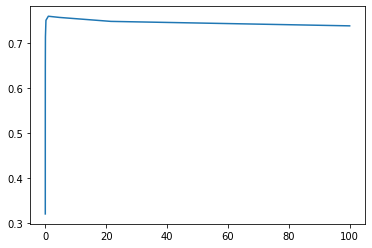

In [68]:
plt.plot(logit_c_values1, logit_mean_cv_scores1);

**Теперь то же самое, только значения параметра `C` перебирайте в диапазоне `np.linspace`(0.1, 7, 20). Опять нарисуйте кривые валидации, определите максимальное значение доли правильных ответов на кросс-валидации.**

In [174]:
%%time
logit_c_values2 = np.linspace(0.1, 7, 20)

logit_grid_searcher2 = LogisticRegressionCV(
    Cs=logit_c_values2,
    random_state=17,
    n_jobs=-1,
    multi_class='multinomial',
    cv=skf)
logit_grid_searcher2.fit(X_train, y_train)

CPU times: user 7.69 s, sys: 564 ms, total: 8.25 s
Wall time: 39.7 s


LogisticRegressionCV(Cs=array([0.1       , 0.46315789, 0.82631579, 1.18947368, 1.55263158,
       1.91578947, 2.27894737, 2.64210526, 3.00526316, 3.36842105,
       3.73157895, 4.09473684, 4.45789474, 4.82105263, 5.18421053,
       5.54736842, 5.91052632, 6.27368421, 6.63684211, 7.        ]),
                     class_weight=None,
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=100, multi_class='multinomial',
                     n_jobs=-1, penalty='l2', random_state=17, refit=True,
                     scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [82]:
logit_grid_searcher2.score(X_train, y_train)

0.8847795163584637

In [175]:
logit_grid_searcher2.C_

array([1.55263158, 1.55263158, 1.55263158, 1.55263158, 1.55263158,
       1.55263158, 1.55263158, 1.55263158, 1.55263158, 1.55263158])

In [176]:
logit_grid_searcher2.C_[0]

1.5526315789473686

In [ ]:
logit_grid_searcher2

In [203]:
cs = []
for i in range(len(logit_grid_searcher2.Cs_)):
    c = logit_c_values2[i]
    scores = list()
    for k,v in logit_grid_searcher2.scores_.items():
        scores.extend(v[:,i])
    cs.append((c, np.mean(scores)))
cs_sorted = sorted(cs, key = lambda x : x[1], reverse= True)
logit_mean_cv_scores2 = [x[1] for x in cs]
logit_mean_cv_scores2

[0.7348111695076108,
 0.759196519502531,
 0.7610254161060356,
 0.7606189739891912,
 0.7616350483072035,
 0.7614319201710761,
 0.7598061826777974,
 0.7593997405609534,
 0.7598061517036994,
 0.7593998025091498,
 0.759298207466988,
 0.7585869802236578,
 0.7577742198863623,
 0.7571646496333907,
 0.7570630236171302,
 0.7559453852310545,
 0.7554374409943431,
 0.7551325939196606,
 0.7541166125239429,
 0.7531005072318325]

In [226]:
cs = []
for i in range(len(logit_grid_searcher2.Cs_)):
    c = logit_c_values2[i]
    scores = list()
    for k,v in logit_grid_searcher2.scores_.items():
        scores.extend(v[:,i])
    cs.append((c, np.max(scores)))
cs = np.array(cs)


In [228]:
np.argmax(cs[:,1])

5

In [202]:
for k, v in logit_grid_searcher2.scores_.items():
    print(np.max(v))

0.774390243902439
0.774390243902439
0.774390243902439
0.774390243902439
0.774390243902439
0.774390243902439
0.774390243902439
0.774390243902439
0.774390243902439
0.774390243902439


Средние значения доли правильных ответов на кросс-валидации по каждому из 10 параметров `C`.

In [ ]:
''' ВАШ КОД ЗДЕСЬ '''

In [195]:
logit_grid_searcher2.C_

array([1.55263158, 1.55263158, 1.55263158, 1.55263158, 1.55263158,
       1.55263158, 1.55263158, 1.55263158, 1.55263158, 1.55263158])

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [77]:
cs_sorted[0][1], cs_sorted[0][0]

(0.7616350483072035, 1.5526315789473686)

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

In [78]:
logit_c_values2 = [x[0] for x in cs]

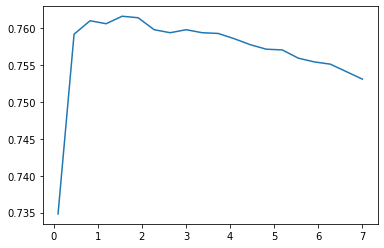

In [79]:
plt.plot(logit_c_values2, logit_mean_cv_scores2);

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для логистической регрессии с лучшим найденным значением `C`.

**<font color='red'>Вопрос 3. </font>Посчитайте доли правильных ответов для `logit_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [89]:
logit_cv_acc = cross_val_score(
    LogisticRegression(C = cs_sorted[0][0],random_state=17, n_jobs=-1), 
    X_train, 
    y_train, 
    cv = skf, 
    n_jobs=-1)
a3_1 = str(round(np.mean(logit_cv_acc),3))
a3_1

'0.762'

In [92]:
logit_valid_acc = accuracy_score(y_valid, logit_grid_searcher2.predict(X_valid))
a3_2 = str(round(logit_valid_acc,3))
a3_2

'0.779'

In [93]:
answer3 = " ".join([a3_1, a3_2])
write_answer(3, answer3)

!cat task4_3_answer

**4. Обучите линейный SVM (`LinearSVC`) с параметром `C`=1 и `random_state`=17 (для воспроизводимости). Посмотрите на долю правильных ответов на кросс-валидации (используйте объект `skf`, созданный ранее) и на выборке `(X_valid, y_valid)`.**

In [96]:
from sklearn.svm import LinearSVC

In [98]:
svm = LinearSVC(C = 1, random_state=17)

**С помощью `GridSearchCV` подберите параметр `C` для SVM сначала в широком диапазоне: 10 значений от 1e-4 до 1e4, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [105]:
%%time
svm_params1 = {'C': np.linspace(1e-4, 1e4, 10)}

svm_grid_searcher1 = GridSearchCV(svm, svm_params1, n_jobs = -1, cv = skf, return_train_score = True)
svm_grid_searcher1.fit(X_train, y_train)

CPU times: user 3.45 s, sys: 140 ms, total: 3.59 s
Wall time: 21.5 s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
             error_score=nan,
             estimator=LinearSVC(C=1, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=17, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([1.0000000e-04, 1.1111112e+03, 2.2222223e+03, 3.3333334e+03,
       4.4444445e+03, 5.5555556e+03, 6.6666667e+03, 7.7777778e+03,
       8.8888889e+03, 1.0000000e+04])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [106]:
svm_grid_searcher1.best_params_, svm_grid_searcher1.best_score_

({'C': 2222.2223000000004}, 0.6868546856376824)

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от `C`.

In [107]:
svm_grid_searcher1.cv_results_

{'mean_fit_time': array([0.14861552, 5.06071297, 5.25968258, 5.4339265 , 4.83416335,
        5.11324128, 5.04311482, 4.87181528, 4.74686869, 2.432386  ]),
 'std_fit_time': array([0.00618847, 0.36262641, 0.23098733, 0.17590846, 0.26711531,
        0.34514473, 0.44318082, 0.25826322, 0.14278064, 0.27188294]),
 'mean_score_time': array([0.00213695, 0.0022881 , 0.00221078, 0.00207392, 0.00209006,
        0.00208028, 0.00215729, 0.00206931, 0.00165828, 0.00109943]),
 'std_score_time': array([6.21600720e-05, 9.82639409e-06, 1.25759165e-04, 6.30595984e-06,
        7.04131331e-06, 1.02941131e-05, 4.61187791e-05, 2.05476921e-05,
        3.10077048e-04, 4.11419259e-05]),
 'param_C': masked_array(data=[0.0001, 1111.1112, 2222.2223000000004,
                    3333.3334000000004, 4444.4445000000005,
                    5555.555600000001, 6666.666700000001,
                    7777.777800000001, 8888.8889, 10000.0],
              mask=[False, False, False, False, False, False, False, False,
      

In [108]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

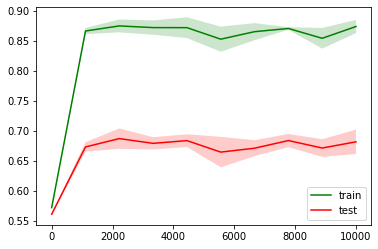

In [109]:
plot_validation_curves(svm_params1['C'], svm_grid_searcher1.cv_results_)

**Но мы помним, что с параметром регуляризации по умолчанию (С=1) на кросс-валидации доля правильных ответов выше. Это тот случай (не редкий), когда можно ошибиться и перебирать параметры не в том диапазоне (причина в том, что мы взяли равномерную сетку на большом интервале и упустили действительно хороший интервал значений `C`). Здесь намного осмысленней подбирать `C` в районе 1, к тому же, так модель быстрее обучается, чем при больших `C`. **

**С помощью `GridSearchCV` подберите параметр `C` для SVM в диапазоне (1e-3, 1), 30 значений, используйте `linspace` из NumPy. Нарисуйте кривые валидации.**

In [110]:
%%time
svm_params2 = {'C': np.linspace(1e-3, 1, 30)}

svm_grid_searcher2 =  GridSearchCV(svm, svm_params2, n_jobs = -1, cv = skf, return_train_score = True)
svm_grid_searcher2.fit(X_train, y_train)

CPU times: user 976 ms, sys: 30.1 ms, total: 1.01 s
Wall time: 32.4 s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
             error_score=nan,
             estimator=LinearSVC(C=1, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=17, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([0.001     , 0.03544828...
       0.17324138, 0.20768966, 0.24213793, 0.27658621, 0.31103448,
       0.34548276, 0.37993103, 0.41437931, 0.44882759, 0.48327586,
       0.51772414, 0.55217241, 0.58662069, 0.62106897, 0.65551724,
       0.68996552, 0.72441379, 0.75886207, 0.79331034, 0.82775862,
       0.8622069 , 0.89665517, 0.93110345, 0.96555172, 1.        ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=Non

Выведите лучшее значение доли правильных ответов на кросс-валидации и соответствующее значение `C`.

In [114]:
 svm_grid_searcher2.best_score_, svm_grid_searcher2.best_params_

(0.7670206386611259, {'C': 0.10434482758620689})

Нарисуйте график зависимости доли правильных ответов на кросс-валидации от С.

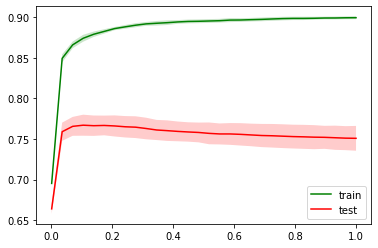

In [113]:
plot_validation_curves(svm_params2['C'], svm_grid_searcher2.cv_results_)

Выведите долю правильных ответов на выборке `(X_valid, y_valid)` для `LinearSVC` с лучшим найденным значением `C`.

In [122]:
svm_cv_acc = accuracy_score(y_valid, svm_grid_searcher2.predict(X_valid))
a4_1 = str(round(svm_cv_acc,3))
a4_1

'0.781'

In [123]:
logit_cross_valid_acc = cross_val_score(
    LinearSVC(C = svm_grid_searcher2.best_params_['C'], random_state=17), 
    X_train, 
    y_train, 
    cv = skf, 
    n_jobs=-1)
a4_2 = str(round(np.mean(logit_cross_valid_acc),3))
a4_2

'0.767'

**<font color='red'>Вопрос 4. </font> Посчитайте доли правильных ответов для `svm_grid_searcher2` на кросс-валидации для лучшего значения параметра `C` и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [124]:
answer4 = " ".join([a4_2, a4_1])
write_answer(4, answer4)

In [125]:
!cat task4_4_answer

0.767 0.781

## Часть 2. Выбор параметров – длины сессии и ширины окна

**Возьмем `LinearSVC`, показавший лучшее качество на кросс-валидации в 1 части, и проверим его работу еще на 8 выборках для 10 пользователей (с разными сочетаниями параметров *session_length* и *window_size*). Поскольку тут уже вычислений побольше, мы не будем каждый раз заново подбирать параметр регуляризации `C`.**

**Определите функцию `model_assessment`, ее документация описана ниже. Обратите внимание на все детали. Например, на то, что разбиение  выборки с `train_test_split` должно быть стратифицированным. Не теряйте нигде `random_state`.**

In [ ]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.

    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split

    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''

    with open(os.path.join(PATH_TO_DATA,          'X_sparse_10users.pkl'), 'rb') as X_sparse_10users_pkl:
    X_sparse_10users = pickle.load(X_sparse_10users_pkl)
    with open(os.path.join(PATH_TO_DATA,                        'y_10users.pkl'), 'rb') as y_10users_pkl:
    y_10users = pickle.load(y_10users_pkl)

    X_train, X_valid, y_train, y_valid = train_test_split(X_sparse_10users, y_10users,
                                                          test_size=0.3,
                                                          random_state=17, stratify=y_10users)

    cross_val_score(
        estimator,
        X,
        y,
        cv)

**Убедитесь, что функция работает.**

In [ ]:
model_assessment(svm_grid_searcher2.best_estimator_, 
                 os.path.join(PATH_TO_DATA, 'X_sparse_10users.pkl'),
        os.path.join(PATH_TO_DATA, 'y_10users.pkl'), skf, random_state=17, test_size=0.3)

**Примените функцию *model_assessment* для лучшего алгоритма из предыдущей части (а именно, `svm_grid_searcher2.best_estimator_`) и 9 выборок вида с разными сочетаниями параметров *session_length* и *window_size* для 10 пользователей. Выведите в цикле параметры *session_length* и *window_size*, а также результат вывода функции *model_assessment*. 
Удобно сделать так, чтоб *model_assessment* возвращала 3-им элементом время, за которое она выполнилась. На моем ноуте этот участок кода выполнился за 20 секунд. Но со 150 пользователями каждая итерация занимает уже несколько минут.**

Здесь для удобства стоит создать копии ранее созданных pickle-файлов X_sparse_10users.pkl, X_sparse_150users.pkl, y_10users.pkl и y_150users.pkl, добавив к их названиям s10_w10, что означает длину сессии 10 и ширину окна 10. 

In [ ]:
!cp $PATH_TO_DATA/X_sparse_10users.pkl $PATH_TO_DATA/X_sparse_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/X_sparse_150users.pkl $PATH_TO_DATA/X_sparse_150users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_10users.pkl $PATH_TO_DATA/y_10users_s10_w10.pkl 
!cp $PATH_TO_DATA/y_150users.pkl $PATH_TO_DATA/y_150users_s10_w10.pkl 

In [ ]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    if window_size <= session_length:
        path_to_X_pkl = ''' ВАШ КОД ЗДЕСЬ '''
        path_to_y_pkl = ''' ВАШ КОД ЗДЕСЬ '''
        print           ''' ВАШ КОД ЗДЕСЬ '''

**<font color='red'>Вопрос 5. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_10users_s15_w5`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [ ]:
''' ВАШ КОД ЗДЕСЬ '''

**Прокомментируйте полученные результаты. Сравните для 150 пользователей доли правильных ответов на кросс-валидации и оставленной выборке для сочетаний параметров (*session_length, window_size*): (5,5), (7,7) и (10,10). На среднем ноуте это может занять до часа – запаситесь терпением, это Data Science :) **

**Сделайте вывод о том, как качество классификации зависит от длины сессии и ширины окна.**

In [ ]:
%%time
estimator = svm_grid_searcher2.best_estimator_

for window_size, session_length in [(5,5), (7,7), (10,10)]:
    path_to_X_pkl = ''' ВАШ КОД ЗДЕСЬ '''
    path_to_y_pkl = ''' ВАШ КОД ЗДЕСЬ '''
    print           ''' ВАШ КОД ЗДЕСЬ '''

**<font color='red'>Вопрос 6. </font> Посчитайте доли правильных ответов для `LinearSVC` с настроенным параметром `C` и выборки `X_sparse_150users`. Укажите доли правильных ответов на кросс-валидации и на отложенной выборке. Округлите каждое до 3 знаков после запятой и выведите через пробел.**

In [ ]:
''' ВАШ КОД ЗДЕСЬ '''

## Часть 3. Идентификация  конкретного пользователя и кривые обучения

**Поскольку может разочаровать, что многоклассовая доля правильных ответов на выборке из 150 пользовалей невелика, порадуемся тому, что конкретного пользователя можно идентифицировать достаточно хорошо. **

**Загрузим сериализованные ранее объекты *X_sparse_150users* и *y_150users*, соответствующие обучающей выборке для 150 пользователей с параметрами (*session_length, window_size*) = (10,10). Так же точно разобьем их на 70% и 30%.**

In [126]:
with open(os.path.join(PATH_TO_DATA, 'X_sparse_150users.pkl'), 'rb') as X_sparse_150users_pkl:
     X_sparse_150users = pickle.load(X_sparse_150users_pkl)
with open(os.path.join(PATH_TO_DATA, 'y_150users.pkl'), 'rb') as y_150users_pkl:
    y_150users = pickle.load(y_150users_pkl)

In [127]:
X_train_150, X_valid_150, y_train_150, y_valid_150 = train_test_split(X_sparse_150users, 
                                                                      y_150users, test_size=0.3, 
                                                     random_state=17, stratify=y_150users)

**Обучите `LogisticRegressionCV` для одного значения параметра `C` (лучшего на кросс-валидации в 1 части, используйте точное значение, не на глаз). Теперь будем решать 150 задач "Один-против-Всех", поэтому укажите аргумент `multi_class`='ovr'. Как всегда, где возможно, указывайте `n_jobs=-1` и `random_state`=17.**

In [204]:
cs_sorted

[(1.5526315789473686, 0.7616350483072035),
 (1.9157894736842107, 0.7614319201710761),
 (0.8263157894736842, 0.7610254161060356),
 (1.1894736842105265, 0.7606189739891912),
 (2.278947368421053, 0.7598061826777974),
 (3.005263157894737, 0.7598061517036994),
 (3.368421052631579, 0.7593998025091498),
 (2.642105263157895, 0.7593997405609534),
 (3.7315789473684213, 0.759298207466988),
 (0.4631578947368421, 0.759196519502531),
 (4.094736842105263, 0.7585869802236578),
 (4.457894736842105, 0.7577742198863623),
 (4.821052631578947, 0.7571646496333907),
 (5.184210526315789, 0.7570630236171302),
 (5.5473684210526315, 0.7559453852310545),
 (5.910526315789474, 0.7554374409943431),
 (6.273684210526316, 0.7551325939196606),
 (6.636842105263158, 0.7541166125239429),
 (7.0, 0.7531005072318325),
 (0.1, 0.7348111695076108)]

In [229]:
logit_grid_searcher2.Cs_[5]

1.9157894736842107

In [230]:
%%time
logit_cv_150users = LogisticRegressionCV(
    Cs=[logit_grid_searcher2.Cs_[5]],
    multi_class='ovr',
    random_state=17,
    n_jobs=-1,
    cv=skf)
logit_cv_150users.fit(X_train_150, y_train_150)

CPU times: user 17min 15s, sys: 53.2 s, total: 18min 8s
Wall time: 7min 20s


LogisticRegressionCV(Cs=[1.9157894736842107], class_weight=None,
                     cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=100, multi_class='ovr', n_jobs=-1,
                     penalty='l2', random_state=17, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

**Посмотрите на средние доли правильных ответов на кросс-валидации в задаче идентификации каждого пользователя по отдельности.**

In [232]:
cv_scores_by_user = {}
for user_id in logit_cv_150users.scores_:
#     print('User {}, CV score: {}'.format(user_id, np.mean(logit_cv_150users.scores_[user_id])))
    cv_scores_by_user[user_id]  = np.mean(logit_cv_150users.scores_[user_id])
cv_scores_by_user

{6: 0.9960797806345333,
 13: 0.9963091551718745,
 15: 0.995256117523172,
 16: 0.9918467778090561,
 28: 0.9903558433163387,
 31: 0.9944011760658097,
 33: 0.9937651830304547,
 39: 0.9859143181841877,
 46: 0.9980398903172666,
 49: 0.9951935608311699,
 50: 0.9943281932584739,
 53: 0.9937130524537862,
 65: 0.9969451482072295,
 66: 0.9948077945638234,
 82: 0.9963717118638766,
 85: 0.9963717118638766,
 89: 0.9908771490830232,
 92: 0.994422028296477,
 100: 0.9944950111038128,
 102: 0.9911586541970326,
 103: 0.9805448687873385,
 105: 0.9969034437458948,
 106: 0.9948494990251583,
 118: 0.9909292796596917,
 119: 0.9965906602858841,
 120: 0.994286488797139,
 126: 0.9950684474471657,
 127: 0.9916069771563812,
 128: 0.9846944626901463,
 138: 0.9970598354759,
 158: 0.9970598354759,
 160: 0.9968200348232252,
 165: 0.997362192820577,
 172: 0.9964863991325471,
 177: 0.9967679042465568,
 203: 0.9975707151272508,
 207: 0.9877805928289178,
 223: 0.9965489558245494,
 233: 0.9963195812872082,
 235: 0.9966636

**Результаты кажутся впечатляющими, но возможно, мы забываем про дисбаланс классов, и высокую долю правильных ответов можно получить константным прогнозом. Посчитайте для каждого пользователя разницу между долей правильных ответов на кросс-валидации (только что посчитанную с помощью `LogisticRegressionCV`) и долей меток в *y_train_150*, отличных от ID 
 этого пользователя (именно такую долю правильных ответов можно получить, если классификатор всегда "говорит", что это не пользователь с номером $i$ в задаче классификации $i$-vs-All).**

In [233]:
class_distr = np.bincount(y_train_150.astype('int'))

In [234]:
sum(class_distr)

95913

In [235]:
class_distr[:7]

array([   0,    0,    0,    0,    0,    0, 1496])

In [236]:
class_distr[6]

1496

In [237]:
(sum(class_distr)-class_distr[6])/sum(class_distr)

0.984402531460803

In [238]:
class_distr = np.bincount(y_train_150.astype('int'))

var = []
for user_id in np.unique(y_train_150):
    var.append(cv_scores_by_user[user_id] - ((sum(class_distr) - class_distr[user_id])/sum(class_distr)))

In [239]:
var

[0.011677249173730253,
 0.000604714689353858,
 0.0008549414573623126,
 0.007131462888242401,
 0.0024084326420819036,
 -5.2130576668418804e-05,
 0.0012198554940414663,
 0.0020018141440680814,
 0.0009174981493643708,
 0.0013658211087130834,
 0.00017724396067275716,
 0.0016681784533899569,
 2.0852230667389726e-05,
 -5.213057666852983e-05,
 2.0852230667389726e-05,
 0.00017724396067264614,
 0.0008028108806940049,
 0.0002710789986758444,
 -0.0002502267680085657,
 0.0007194019580243349,
 0.003544879213453811,
 0.0008862198033635638,
 0.007631916424259533,
 0.0009279242646983432,
 0.0006464191506886374,
 0.0006255669200211367,
 0.001011333187367791,
 0.00409746332613925,
 0.005098370398173291,
 -5.2130576668418804e-05,
 0.00028150511400959477,
 0.00028150511400959477,
 0.00028150511400959477,
 0.00022937453734106494,
 0.0002710789986759554,
 0.0013866733393805841,
 0.0014179516853815022,
 8.34089226695589e-05,
 8.34089226695589e-05,
 -8.34089226695589e-05,
 0.001240707724708856,
 0.00140752557

In [240]:
num_better_than_default = (np.array(var)>0).sum()
num_better_than_default

127

In [187]:
users_number = len(np.unique(y_train_150))
users_number

150

In [ ]:
num_better_than_default = (np.array(list(acc_diff_vs_constant.values())) > 0).sum()

In [190]:
129/150

0.86

**<font color='red'>Вопрос 7. </font> Посчитайте долю пользователей, для которых логистическая регрессия на кросс-валидации дает прогноз лучше константного. Округлите до 3 знаков после запятой.**

In [163]:
a7 = str(round(num_better_than_default/users_number,3))
a7

'0.86'

In [164]:
write_answer(7,a7)

In [165]:
!cat task4_7_answer

0.86

**Дальше будем строить кривые обучения для конкретного пользователя, допустим, для 128-го. Составьте новый бинарный вектор на основе *y_150users*, его значения будут 1 или 0 в зависимости от того, равен ли ID-шник пользователя 128.**

In [ ]:
y_binary_128 = ''' ВАШ КОД ЗДЕСЬ '''

In [ ]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(val_train, val_test, train_sizes, 
                        xlabel='Training Set Size', ylabel='score'):
    def plot_with_err(x, data, **kwargs):
        mu, std = data.mean(1), data.std(1)
        lines = plt.plot(x, mu, '-', **kwargs)
        plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                         facecolor=lines[0].get_color(), alpha=0.2)
    plot_with_err(train_sizes, val_train, label='train')
    plot_with_err(train_sizes, val_test, label='valid')
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.legend(loc='lower right');

**Посчитайте доли правильных ответов на кросс-валидации в задаче классификации "user128-vs-All" в зависимости от размера выборки. Не помешает посмотреть встроенную документацию для *learning_curve*.**

In [ ]:
%%time
train_sizes = np.linspace(0.25, 1, 20)
estimator = svm_grid_searcher2.best_estimator_
n_train, val_train, val_test = learning_curve ''' ВАШ КОД ЗДЕСЬ '''

In [ ]:
plot_learning_curve(val_train, val_test, n_train, 
                    xlabel='train_size', ylabel='accuracy')

**Сделайте выводы о том, помогут ли алгоритму новые размеченные данные при той же постановке задачи.**

## Пути улучшения
- конечно, можно проверить еще кучу алгоритмов, например, Xgboost, но в такой задаче очень маловероятно, что что-то справится лучше линейных методов
- интересно проверить качество алгоритма на данных, где сессии выделялись не по количеству посещенных сайтов, а по времени, например, 5, 7, 10 и 15 минут. Отдельно стоит отметить данные нашего [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) 
- опять же, если ресурсы позволяют, можно проверить, насколько хорошо можно решить задачу для 3000 пользователей


На следующей неделе мы вспомним про линейные модели, обучаемые стохастическим градиентным спуском, и порадуемся тому, насколько быстрее они работают. Также сделаем первые (или не первые) посылки в [соревновании](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) Kaggle Inclass.